<a href="https://colab.research.google.com/github/aronsalinas96/machine_learning/blob/main/supermarket_beer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de las ventas de cerveza en una cadena de supermercados

### Descripción del problema

En el siguiente análisis vamos a estudiar las ventas de cervezas en una cadena de supermercados durante el mes de Junio de 2018. Para ello contamos con dos ficheros de entrada:

* `master_articles.h5`: contiene la información del maestro de articulos. Tiene los siguientes campos:
 * `Articulo_Codigo` : identificador único del artículo
 * `Articulo_Nombre` : nombre del articulo
 * `GVSV`: categoría a la que pertenece el artículo (cervezas, bebidas refrescantes, café, etc.)
* `beer_sales.h5`: contiene todos los tickets de venta de cervezas (a nivel de línea de ticket). Tiene los siguientes campos:
 * `articulo`: identificador único del artículo comprado
 * `cantidad`: unidades compradas de ese artículo en el ticket
 * `importe`: importe en euros de ese artículo en el ticket
 * `tienda`: identificador único de la tienda donde se produjo la linea de ticket
 * `caja`: identificador de la caja registradora en la que se produjo la linea de ticket
 * `dia`: dia en el que se produjo la linea de ticket
 * `hora`: hora en la que se produjo la linea de ticket
 * `minuto`: minuto en el que se produjo la linea de ticket
 * `ticket`: identificador NO único del ticket (es un identificador del ticket por tienda y caja)

### Desarrollo de la solución

En primer lugar, nos gustaría traernos el nombre de cada artículo al dataset de tickets.

In [1]:
!pip install pandasql

In [2]:
import pandas as pd
import pandasql as ps
import seaborn as sns
pd.options.mode.chained_assignment = None
from IPython.display import display_html 

path_articles = "master_articles.h5"
path_tickets = "beer_sales.h5"

df_articles = pd.read_hdf(path_articles)
df_tickets = pd.read_hdf(path_tickets)

In [3]:
df_articles.head()

,Articulo_Codigo,Articulo_Nombre,GVSV
0,6291,PIZZA ART.MOZZARELLA COCINE;E.330 G,4509
1,6292,PIZZA ART.AT/BACON COCINERA375,4509
2,6293,"PIZZA ROMANA COCINERA,EST.300G",4509
3,6343,CUCHARILLA DE MOKA,8507
4,6347,SALMON AHUMADO FREIREMAR; EST.150 G,4505


In [4]:
df_tickets.head()

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda
0,19519,3,1.0,23,13,6.12,19,137,14808
1,19519,3,1.0,29,11,6.12,52,78,14808
2,7571,2,6.0,30,18,3.90,37,310,14967
3,8128,3,1.0,5,13,0.00,44,57,14214
4,13340,3,1.0,5,13,0.00,44,57,14214


In [5]:
df_sales_articles = pd.merge(df_tickets, df_articles[['Articulo_Codigo','Articulo_Nombre']], 
                             how="inner", left_on='articulo', right_on='Articulo_Codigo')
df_sales_articles.head()

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,Articulo_Codigo,Articulo_Nombre
0,19519,3,1.0,23,13,6.12,19,137,14808,19519,SAN MIGUEL 12X33cl.
1,19519,3,1.0,29,11,6.12,52,78,14808,19519,SAN MIGUEL 12X33cl.
2,19519,3,1.0,15,20,6.12,31,215,14720,19519,SAN MIGUEL 12X33cl.
3,19519,2,1.0,18,19,6.12,24,344,14090,19519,SAN MIGUEL 12X33cl.
4,19519,5,1.0,5,18,6.12,55,198,14090,19519,SAN MIGUEL 12X33cl.


Formateamos la fecha para tenerla lista por si hace falta después

In [6]:
import datetime

dataset_year = '2018'
dataset_month = '6'

def calculate_date(n_day, month, year):
  d = int(n_day)
  assert( (d >= 1) & (d <= 31)), 'Día no válido'
  str_date = n_day+ '/' + month + '/' + year
  return datetime.datetime.strptime(str_date,'%d/%m/%Y').date()

def calculate_time(hour, minute):
  h = int(hour)
  m = int(minute)
  assert((h >= 0) & (h <= 24)) , "Hora inválida"
  assert((m >= 0) & (m <= 60)), "Minuto inválido"
  return datetime.time(h, m, 0)

df_sales_articles['fecha'] = df_sales_articles.apply(lambda x: calculate_date(x['dia'], dataset_month, dataset_year), axis=1)
df_sales_articles['hora_completa'] =  df_sales_articles.apply(lambda x: calculate_time(x['hora'], x['minuto']), axis=1)
df_sales_articles.drop(columns=["hora", "minuto"], inplace=True)

In [7]:
df_sales_articles.head()

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
0,19519,3,1.0,23,6.12,137,14808,19519,SAN MIGUEL 12X33cl.,2018-06-23,13:19:00
1,19519,3,1.0,29,6.12,78,14808,19519,SAN MIGUEL 12X33cl.,2018-06-29,11:52:00
2,19519,3,1.0,15,6.12,215,14720,19519,SAN MIGUEL 12X33cl.,2018-06-15,20:31:00
3,19519,2,1.0,18,6.12,344,14090,19519,SAN MIGUEL 12X33cl.,2018-06-18,19:24:00
4,19519,5,1.0,5,6.12,198,14090,19519,SAN MIGUEL 12X33cl.,2018-06-05,18:55:00


### **Test 1**: Comprobamos que no se pierdan registros con la inner join (alternativa usar left/right join + corregir nulos)


### **Test 2:** Comprobar que haya más de un producto con nombre distinto 

In [8]:
assert df_sales_articles.shape[0] == df_tickets.shape[0], "Faltan articulos"
assert df_sales_articles['Articulo_Nombre'].unique().shape[0] > 1, "1 o ningun nombre, probablemente error!"

Como se ha explicado en la descripción del problema, el campo `ticket` del dataset de ventas no es único. Es decir, puede haber líneas de ticket que compartan valor de `ticket` sin pertenecer necesariamente al mismo ticket. Dada la información disponible, ¿se te ocurre alguna manera de generar un id de ticket que identifique unequívocamente las lineas que pertenecen a un mismo ticket?

###Cálculo ID
Probaremos con varias combinaciones de campos para ver si alguno nos identifica de forma única a un ticket.

In [9]:
df_sales_articles.info() #No hay nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45835 entries, 0 to 45834
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   articulo         45835 non-null  int64  
 1   caja             45835 non-null  object 
 2   cantidad         45835 non-null  float64
 3   dia              45835 non-null  object 
 4   importe          45835 non-null  float64
 5   ticket           45835 non-null  object 
 6   tienda           45835 non-null  int64  
 7   Articulo_Codigo  45835 non-null  int64  
 8   Articulo_Nombre  45835 non-null  object 
 9   fecha            45835 non-null  object 
 10  hora_completa    45835 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 4.2+ MB


In [10]:
df_sales_articles[['tienda','ticket']].duplicated().unique()

array([False,  True])

In [11]:
df_sales_articles[['tienda', 'caja', 'ticket','fecha', 'hora_completa']].duplicated().unique()

array([False,  True])

In [12]:
df_sales_articles[['tienda', 'caja', 'ticket','fecha', 'hora_completa', 'articulo']].duplicated().unique()

array([False,  True])

In [13]:
df_sales_articles[df_sales_articles[['tienda','ticket','fecha', 'hora_completa','articulo']].duplicated()==True].head()

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
3238,7571,4,1.0,27,0.65,92,14129,7571,ESTR.GALICIA 33cl.,2018-06-27,20:16:00
6279,8128,2,0.0,12,-0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00
7032,8128,5,0.0,4,-0.27,16,14097,8128,MOLENBIER 33cl.,2018-06-04,11:25:00
8435,8128,4,0.0,2,-0.27,106,14209,8128,MOLENBIER 33cl.,2018-06-02,12:34:00
9920,8128,3,3.0,12,0.75,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00


In [14]:
df_sales_articles[(df_sales_articles['ticket'] == '56') & 
                  (df_sales_articles['tienda'] == 14093) & 
                  (df_sales_articles['articulo'] == 88232)]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
44062,88232,7,1.0,11,0.6,56,14093,88232,CRUZCAMPO ESPECIAL L33cl.,2018-06-11,13:18:00
44063,88232,7,1.0,11,0.3,56,14093,88232,CRUZCAMPO ESPECIAL L33cl.,2018-06-11,13:18:00


In [15]:
df_sales_articles[df_sales_articles[['tienda', 'caja', 'ticket','fecha', 'hora_completa', 'articulo','importe']].duplicated()==True]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
3238,7571,4,1.0,27,0.65,92,14129,7571,ESTR.GALICIA 33cl.,2018-06-27,20:16:00
20960,14907,2,1.0,25,0.52,196,14216,14907,MAHOU CLASICA 33cl.,2018-06-25,16:34:00
26321,11213,4,1.0,19,0.53,78,14809,11213,SAN MIGUEL 33cl.,2018-06-19,11:24:00
31515,11213,3,1.0,8,0.52,189,14040,11213,SAN MIGUEL 33cl.,2018-06-08,17:04:00
31684,11213,2,1.0,23,0.52,315,14551,11213,SAN MIGUEL 33cl.,2018-06-23,17:51:00
33475,11213,2,1.0,25,0.53,101,14841,11213,SAN MIGUEL 33cl.,2018-06-25,11:36:00
34402,8133,4,1.0,4,0.39,33,14033,8133,MOLENBIER100%MALT 33cl.,2018-06-04,13:06:00
40146,18495,2,1.0,18,0.86,313,14721,18495,SAN MIGUEL 50cl.,2018-06-18,17:47:00


In [16]:
df_sales_articles[(df_sales_articles['ticket'] == '92') & 
                  (df_sales_articles['tienda'] == 14129) &
                  (df_sales_articles['articulo'] == 7571)]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
3237,7571,4,1.0,27,0.65,92,14129,7571,ESTR.GALICIA 33cl.,2018-06-27,20:16:00
3238,7571,4,1.0,27,0.65,92,14129,7571,ESTR.GALICIA 33cl.,2018-06-27,20:16:00


Parece que hay registros duplicados para la  la misma [tienda, ticket, articulo_id, fecha, importe]
Probablemente sea un error en el origen de la información habría que consultar a quien nos facilita los datos

Eliminaremos los registros duplicados


In [17]:
df_sales_articles_nodup = df_sales_articles.drop_duplicates()
df_sales_articles_nodup[df_sales_articles_nodup[['tienda', 'caja', 'ticket', 'articulo', 'fecha', 'hora_completa']].duplicated()==True].head()

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
6279,8128,2,0.0,12,-0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00
7032,8128,5,0.0,4,-0.27,16,14097,8128,MOLENBIER 33cl.,2018-06-04,11:25:00
8435,8128,4,0.0,2,-0.27,106,14209,8128,MOLENBIER 33cl.,2018-06-02,12:34:00
9920,8128,3,3.0,12,0.75,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00
11332,13340,2,0.0,11,-0.41,246,14122,13340,SKOL 33cl.,2018-06-11,16:46:00


In [18]:
df_sales_articles[(df_sales_articles['ticket'] == '131') & 
                  (df_sales_articles['tienda'] == 14835) &
                  (df_sales_articles['articulo'] == 8128)]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
6278,8128,2,1.0,12,0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00
6279,8128,2,0.0,12,-0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00


El dataset incluye devoluciones, por lo que hay dos opciones:
1. Eliminar tickets que hayan sido devueltos.
2. Incluir el importe como id y luego tener en cuenta en posteriores cálculos la resta de importe por devolución.

Para evitar cálculos adicionales, vamos a eliminarlos del dataset

In [19]:
df_clean = df_sales_articles_nodup.copy()
df_clean['importe'] = df_clean['importe'].abs()
df_clean = df_clean.drop_duplicates()

In [20]:
cols = ['tienda', 'caja', 'ticket', 'articulo', 'fecha', 'hora_completa']
df_clean[df_clean[cols].duplicated()==True].head()

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
6279,8128,2,0.0,12,0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00
7032,8128,5,0.0,4,0.27,16,14097,8128,MOLENBIER 33cl.,2018-06-04,11:25:00
8435,8128,4,0.0,2,0.27,106,14209,8128,MOLENBIER 33cl.,2018-06-02,12:34:00
9920,8128,3,3.0,12,0.75,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00
11332,13340,2,0.0,11,0.41,246,14122,13340,SKOL 33cl.,2018-06-11,16:46:00


In [21]:
df_clean[(df_clean['ticket'] == '131') & 
                  (df_clean['tienda'] == 14835) &
                  (df_clean['articulo'] == 8128)]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
6278,8128,2,1.0,12,0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00
6279,8128,2,0.0,12,0.25,131,14835,8128,MOLENBIER 33cl.,2018-06-12,18:20:00


Hay articulos cuya cantidad es 0, los eliminaremos pues no tiene sentido.

In [22]:
df_clean = df_clean[df_clean['cantidad'] != 0.0]
df_clean[df_clean[cols].duplicated()==True].head()

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
9920,8128,3,3.0,12,0.75,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00
16493,7643,4,3.0,1,1.89,69,14836,7643,HEINEKEN 33cl.,2018-06-01,11:05:00
27215,11213,4,3.0,30,1.56,119,14716,11213,SAN MIGUEL 33cl.,2018-06-30,12:22:00
29630,11213,3,2.0,13,1.06,64,14701,11213,SAN MIGUEL 33cl.,2018-06-13,11:32:00
34566,8133,5,17.0,1,6.46,64,14548,8133,MOLENBIER100%MALT 33cl.,2018-06-01,11:12:00


In [23]:
df_clean[(df_clean['ticket'] == '126') & 
                  (df_clean['tienda'] == 14065) &
                  (df_clean['articulo'] == 8128)]

,articulo,caja,cantidad,dia,importe,ticket,tienda,Articulo_Codigo,Articulo_Nombre,fecha,hora_completa
9919,8128,3,1.0,12,0.25,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00
9920,8128,3,3.0,12,0.75,126,14065,8128,MOLENBIER 33cl.,2018-06-12,17:44:00


Parece que el mismo articulo fue comprado en el mismo instante en la misma tienda-caja-ticket, con distintas cantidades, así que vamos a agregarlos sumando cantidad e importe.

In [24]:
#De forma nativa con pandas quizás tenga mayor performance
df_clean_agg = ps.sqldf("""select tienda, caja, ticket, articulo, Articulo_Nombre, 
                        sum(cantidad) as s_cantidad, sum(importe) as s_importe,
                        dia, fecha, hora_completa 
                        from df_clean 
                        group by 
                        tienda, caja, ticket, articulo, Articulo_Nombre, dia, fecha, hora_completa
                        """)
df_clean_agg.head(),df_clean_agg.shape

(   tienda caja ticket  articulo    Articulo_Nombre  s_cantidad  s_importe dia  \
 0   14018    2      1     10486   KELER LUXE 33cl.         2.0       1.00  12   
 1   14018    2      1     10486   KELER LUXE 33cl.         2.0       1.00   9   
 2   14018    2      1     11213   SAN MIGUEL 33cl.         1.0       0.52   9   
 3   14018    2     10     10486   KELER LUXE 33cl.         2.0       1.00   9   
 4   14018    2    103     10486   KELER LUXE 33cl.         6.0       3.36   1   
 
         fecha    hora_completa  
 0  2018-06-12  09:03:00.000000  
 1  2018-06-09  08:08:00.000000  
 2  2018-06-09  08:08:00.000000  
 3  2018-06-09  09:19:00.000000  
 4  2018-06-01  11:58:00.000000  , (45792, 10))

Para crear una id hay varias opciones:
1. Numérico autosecuencial: habría que comprobar que el registro no existe por la pk **['tienda', 'caja', 'ticket', 'articulo', 'fecha', hora_completa']** y luego la id es simplemente secuencial
2. Concatenar los campos que conforman la id y calcular el hash MD5.

Vamos con la opción 2.

In [25]:
import hashlib

keys = ['tienda', 'caja', 'ticket', 'articulo', 'fecha', 'hora_completa']
df_clean_agg['id'] = df_clean_agg[keys].apply(
    lambda x: hashlib.md5('_'.join(x.astype(str)).encode()).hexdigest(),
    axis=1
)
df_clean_agg.head()

,tienda,caja,ticket,articulo,Articulo_Nombre,s_cantidad,s_importe,dia,fecha,hora_completa,id
0,14018,2,1,10486,KELER LUXE 33cl.,2.0,1.00,12,2018-06-12,09:03:00.000000,e7ace5d9e71911ee9b36b6de80d7cb90
1,14018,2,1,10486,KELER LUXE 33cl.,2.0,1.00,9,2018-06-09,08:08:00.000000,bc46a87b664bcb7bbe3404f4c49e2f95
2,14018,2,1,11213,SAN MIGUEL 33cl.,1.0,0.52,9,2018-06-09,08:08:00.000000,bf4dab88ddf0195282c736f7ff64c19f
3,14018,2,10,10486,KELER LUXE 33cl.,2.0,1.00,9,2018-06-09,09:19:00.000000,fce70022eaab04ac43156b106cbe6dd3
4,14018,2,103,10486,KELER LUXE 33cl.,6.0,3.36,1,2018-06-01,11:58:00.000000,107944c2c6e86c6dae8704c39a02099d


###Test 3: Comprobar ID es válida

In [26]:
assert True not in df_clean_agg['id'].duplicated().unique() , "La id no es única!"

¿Se te ocurre alguna manera de verificar que el identificador generado agrupa correctamente las líneas de ticket? ¿Qué consecuencias crees que podría tener el no generarlo correctamente?

Verificando que no haya duplicados con el id generado. Si no se genera correctamente tendríamos duplicados y luego cualquier cálculo sobre los datos sería erróneo.

Ahora, nos gustaría ver en un gráfico las ventas por articulo del TOP 10 de cervezas más vendidas.

In [27]:
import pandasql as ps
import seaborn as sns

top_10_cervezas = ps.sqldf("select Articulo_nombre, sum(s_cantidad) as total from df_clean_agg group by Articulo_nombre order by 2 desc LIMIT 10")
top_10_cervezas.head(10)

,Articulo_Nombre,total
0,SAN MIGUEL 33cl.,59489.0
1,HEINEKEN 33cl.,27120.0
2,MOLENBIER 33cl.,26989.0
3,KELER LUXE 33cl.,23352.0
4,MAHOU 5 EST 33cl.,19045.0
5,ESTR.GALICIA 33cl.,14915.0
6,AMSTEL CLASICA 33cl.,11498.0
7,MAHOU CLASICA 33cl.,10568.0
8,AMSTEL 33cl.,8944.0
9,ESTRELLA DAMM 33cl.,4994.0


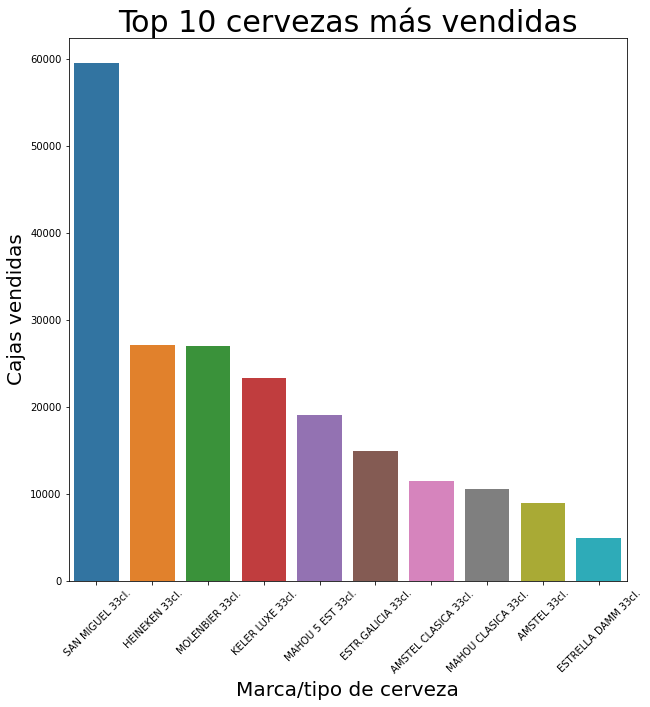

In [28]:
import matplotlib.pyplot as plt
fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x=top_10_cervezas.columns.values[0],
            y=top_10_cervezas.columns.values[1],
            data=top_10_cervezas)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("Top 10 cervezas más vendidas", fontsize=30)
ax.set_ylabel("Cajas vendidas",fontsize=20)
ax.set_xlabel("Marca/tipo de cerveza",fontsize=20)
plt.show()

Se han detectado una serie de tickets anómalos en los que la cantidad de cervezas compradas es extremadamente alto. ¿Como harías para detectarlos y filtrarlos de nuestro conjunto de ventas?

Primero habría que detectarlos estadísticamente, para ello se suelen usar las boxplot donde se ven rápidamente los outliers.

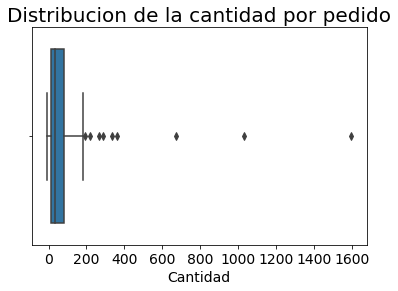

In [29]:
ax = sns.boxplot(x=df_clean_agg['s_cantidad'].unique()) #Para facilitar visualización, tomamos valores únicos.
plt.xticks(fontsize=14)
plt.xlabel('Cantidad', fontsize=14)
plt.title('Distribucion de la cantidad por pedido', fontsize=20)
plt.show()

Luego para eliminarlos se me ocurren varias opciones:

1. Quedarnos con los datos comprendidos en el rango intercuartílico IQR (quedarnos con los valores de la cajita de la gráfica)
2. Quedarnos con los datos incluidos en un percentil alto (entre 95 y 99 por ejemplo).
2. Un modelo no supervisado para predecir anomalías, K-means o Isolation Forest por ejemplo. Requeriría bastante más esfuerzo que simplemente aplicar un método estadístico

Vamos con la opción 1

In [30]:
Q1 = df_clean_agg['s_cantidad'].quantile(0.25)
Q3 = df_clean_agg['s_cantidad'].quantile(0.75)
IQR = Q3 - Q1    

filter = (df_clean_agg['s_cantidad'] >= Q1 - 1.5 * IQR) & (df_clean_agg['s_cantidad'] <= Q3 + 1.5 *IQR)
df_clean_agg_no_outliers = df_clean_agg[filter]

#Ordenamos y miramos los primeros 5 valores y vemos que son cantidades 'normales'
df_clean_agg_no_outliers.sort_values(by=['s_cantidad'], ascending=False)['s_cantidad'].unique()[0:5]

array([13., 12., 11., 10.,  9.])

¿Se te ocurre alguna manera de automáticamente detectar estos tickets en el futuro? ¿Y algún motivo de su presencia?

Se podría automatizar en batch o real-time con un modelo no supervisado como he comentado en el apartado anterior de manera que se clasifique si un ticket es anómalo. 

Para ver el motivo de su presencia una vez detectado los outliers habría que revisar las correlaciones de la cantidad con el resto de variables para encontrar la causa de la misma (si es que existe). 

Un scatterplot sería un buen comienzo.

A continuación, nos gustaría analizar qué cervezas se compran juntas más a menudo. Para ello, a partir de los tickets, calcularemos el número de veces que se compran cada par de articulos conjuntamente (en el mismo ticket).

Podemos agregar y quedarnos con los pares de combinaciones más comunes, vamos a quedarnos solo con los 10 primeros.

In [31]:
from itertools import combinations
from collections import Counter

Counter([
    t for _, d in df_clean_agg_no_outliers.groupby(['tienda','caja', 'ticket','fecha','hora_completa']).Articulo_Nombre
    for t in combinations(d, 2)
]).most_common(10)

[((' MOLENBIER 33cl.', ' SKOL 33cl.'), 272),
 ((' SAN MIGUEL 33cl.', ' SAN MIGUEL 50cl.'), 91),
 ((' HEINEKEN 33cl.', ' SAN MIGUEL 33cl.'), 68),
 ((' MOLENBIER 33cl.', ' SAN MIGUEL 33cl.'), 62),
 ((' KELER LUXE 33cl.', ' SAN MIGUEL 33cl.'), 54),
 ((' MOLENBIER 33cl.', ' MOLENBIER100%MALT 33cl.'), 50),
 ((' HEINEKEN 33cl.', ' KELER LUXE 33cl.'), 47),
 ((' MAHOU 5 EST 33cl.', ' MAHOU CLASICA 33cl.'), 39),
 ((' ESTR.GALICIA 33cl.', ' MOLENBIER 33cl.'), 38),
 ((' ESTR.GALICIA 33cl.', ' SAN MIGUEL 33cl.'), 32)]

¿Se te ocurre alguna posible manera de optimizar este cálculo?

Creando un índice por los campos que agrupamos.

Otra opción es crear un modelo no supervisado para calcular (aproximar más bien) las reglas de asociación entre la compra de cervezas. El algoritmo de Apriori sería un ejemplo típico

¿Qué utilidad crees que puede tener esta información?

Sería un modelo aplicable a un sistema recomendador, donde si vas a comprar una cerveza y sabes que tiene una alta relación con otra cerveza que no se ha comprado, se puede ofrecer para venderla también.

EXTRA: Por último, nos gustaría ver como evoluciona la venta de cervezas a lo largo de la semana y por tramos horarios. ¿Podrías representar esto en un único gráfico? ¿Qué utilidad de negocio crees que tendría esta información segmentada?

### Evolución de ventas respecto al tiempo

Vamos a crear dos gráficas que me parece más interesante así:

1. Evolución de las ventas de cerveza a lo largo del mes
2. Evolución de las ventas de cerveza a lo largo de la semana (ésta responde a la pregunta)

#### Gráfico ventas mes 

Cálculamos el nombre del día y la semana del mes para luego representarlos con un lineplot, que es ideal para representar variaciones respecto al tiempo

In [32]:
import datetime

df_final = df_clean_agg_no_outliers.copy()
df_final['fecha'] = pd.to_datetime(df_final['fecha'])

def day_name(date):
  return date.day_name()

def week_number_of_month(date_value):
     return (date_value.isocalendar()[1] - date_value.replace(day=1).isocalendar()[1] + 1)

df_final['nombre_dia'] = df_final.apply(lambda x: day_name(x['fecha']), axis=1)
day_name_spanish = {'Monday': 'Lunes', 
                    'Tuesday': 'Martes', 
                    'Wednesday': 'Miércoles', 
                    'Thursday': 'Jueves',
                    'Friday':'Viernes',
                    'Saturday': 'Sábado',
                    'Sunday': 'Domingo'
                    }
df_final['nombre_dia'] = df_final['nombre_dia'].replace(day_name_spanish)
df_final['n_semana'] = df_final.apply(lambda x: week_number_of_month(x['fecha']), axis=1)
df_final.head()

,tienda,caja,ticket,articulo,Articulo_Nombre,s_cantidad,s_importe,dia,fecha,hora_completa,id,nombre_dia,n_semana
0,14018,2,1,10486,KELER LUXE 33cl.,2.0,1.00,12,2018-06-12,09:03:00.000000,e7ace5d9e71911ee9b36b6de80d7cb90,Martes,3
1,14018,2,1,10486,KELER LUXE 33cl.,2.0,1.00,9,2018-06-09,08:08:00.000000,bc46a87b664bcb7bbe3404f4c49e2f95,Sábado,2
2,14018,2,1,11213,SAN MIGUEL 33cl.,1.0,0.52,9,2018-06-09,08:08:00.000000,bf4dab88ddf0195282c736f7ff64c19f,Sábado,2
3,14018,2,10,10486,KELER LUXE 33cl.,2.0,1.00,9,2018-06-09,09:19:00.000000,fce70022eaab04ac43156b106cbe6dd3,Sábado,2
4,14018,2,103,10486,KELER LUXE 33cl.,6.0,3.36,1,2018-06-01,11:58:00.000000,107944c2c6e86c6dae8704c39a02099d,Viernes,1


In [33]:
df_final_agg  = ps.sqldf("""select n_semana, dia, nombre_dia, sum(s_cantidad) as total_ventas_dia 
                from df_final 
                group by n_semana, dia, nombre_dia""")
df_final_agg.head()

,n_semana,dia,nombre_dia,total_ventas_dia
0,1,1,Viernes,8435.0
1,1,2,Sábado,8447.0
2,1,3,Domingo,415.0
3,2,10,Domingo,366.0
4,2,4,Lunes,6300.0


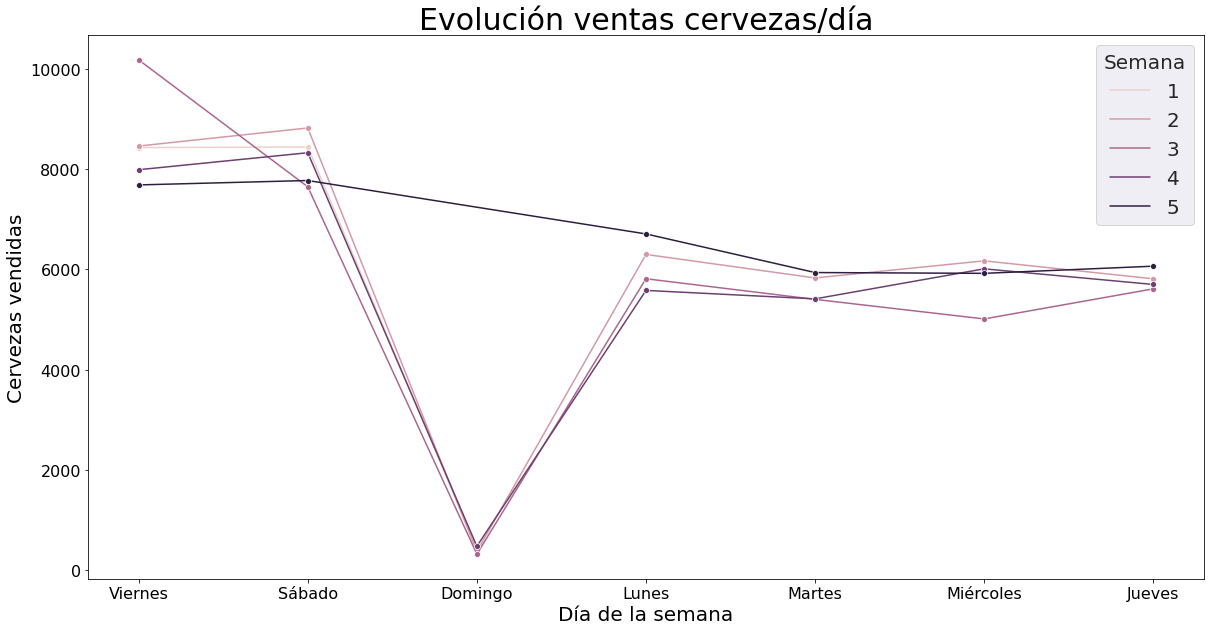

In [34]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.set_theme()
sns.lineplot(
    data=df_final_agg,
    x="nombre_dia", 
    y="total_ventas_dia",
    hue="n_semana",
    legend="full",
    marker='o',
    ci=None
)
plt.legend(title="Semana", fontsize=20, title_fontsize=20)
ax.set_title("Evolución ventas cervezas/día", fontsize=30)
ax.set_xlabel("Día de la semana",fontsize=20)
ax.set_ylabel("Cervezas vendidas",fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

#### Conclusiones evolución ventas mensuales:
1. Los domingos no se compra prácticamente cerveza, a excepción de la semana 5.
2. Se mantienen las tendencias para cada semana a lo largo del mes

#### Gráfica ventas día/hora

Para mostrar el paso del tiempo truncamos y agrupamos por hora, así facilitamos la visualización. En realidad habría que redondear a la hora más cercana pero me da pereza el cálculo 💤

In [35]:
df_final_agg_hora  = ps.sqldf("""select substr(hora_completa,1,2) as hora , dia, nombre_dia, sum(s_cantidad) as s_cantidad
                from df_final
                group by n_semana, nombre_dia, substr(hora_completa,1,2)
                order by hora
                """)
df_final_agg_hora.head()

,hora,dia,nombre_dia,s_cantidad
0,07,26,Martes,12.0
1,08,2,Sábado,22.0
2,08,7,Jueves,6.0
3,08,5,Martes,1.0
4,08,6,Miércoles,13.0


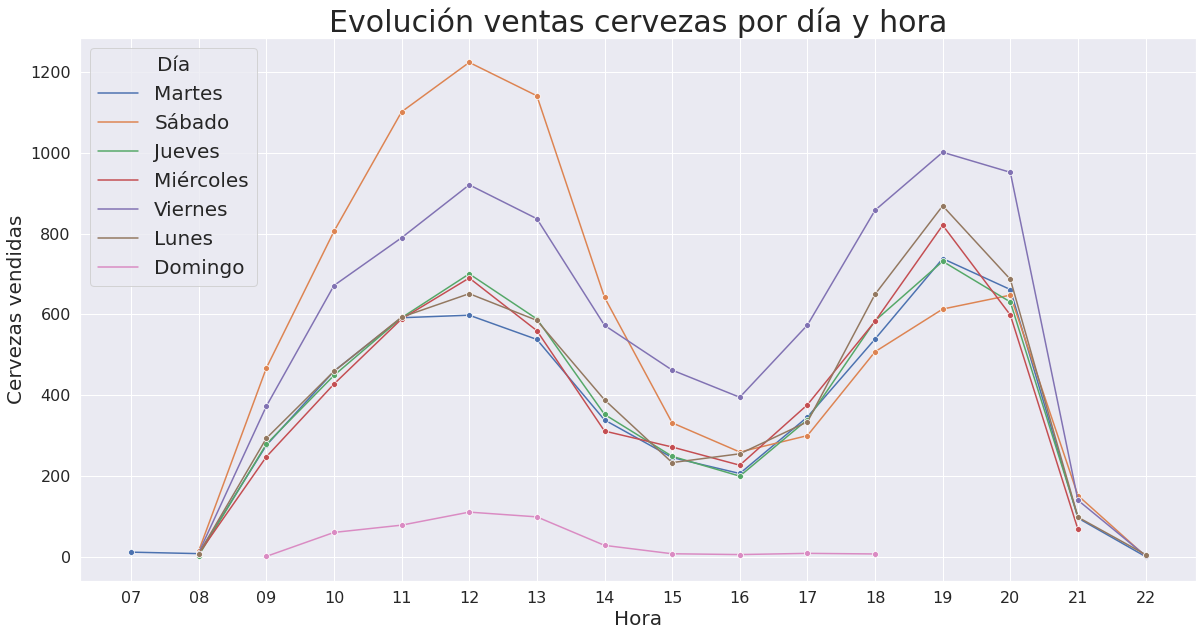

In [36]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)

sns.set_theme()
sns.lineplot(
    data=df_final_agg_hora,
    x="hora", 
    y="s_cantidad",
    hue="nombre_dia",
    legend="full",
    marker='o',
    ci=None
)
plt.legend(title="Día", fontsize=20, title_fontsize=20)
ax.set_title("Evolución ventas cervezas por día y hora", fontsize=30)
ax.set_xlabel("Hora",fontsize=20)
ax.set_ylabel("Cervezas vendidas",fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.show()

#### Conclusiones evolución ventas día/hora
1. Casi nadie compra cerveza los Domingos, normal el lunes hay que trabajar 👷
2. Por contra, el Sábado es el día en que más se compra --> Sábado noche 🕺
3. Las compras se focalizan alrededor de las 12 o de las 19-18, probablemente porque van a ser consumidas a la hora del almuerzo/cena 🍻

EXTRA: ¿Qué usos de Machine Learning verías aplicables a este conjunto de datos?

## Casos de uso ML

Se me ocurren varios casos de uso

1. Personalización - Aumentar CTR y Ratio de Conversión: aplicando un algoritmo recomendador para la venta de cervezas podría aumentar el número de ventas, como ya he comentado en una sección anterior. Habría que aplicar algún algoritmo no supervisado para calcular los diferentes perfiles.
2. Ranking por resultados: supongamos que el comercio tiene una web, podrías mostrar las cervezas ordenadas por las que más se compran. Va bastante en relación con el punto anterior.
3. Calcular precio óptimo de la cerveza: se podría alterar el precio de la cerveza basado en como de frecuente los usuarios compran si ven la cerveza en un rango específico de precios, dicho de otro modo, calcular el precio más alto al que se pueden vender sin perder número de compras. Aquí hay varias opciones, se puede hacer en base al perfil del cliente, en base a la fecha o incluse región demográfica.
4. Gestión de inventario y predicción de ventas: se podría hacer un modelo de series temporales (Deep Learning, pero llevan bastante trabajo) o algún método estadístico para predecir el número de ventas de cada cerveza, y poder adelantarte a que se acabe el stock con lo que gestionas mejor las compras con los proveedores. Un ARIMA sería un buen comienzo.

### Nota

No he tenido mucho tiempo para realizar el test, ya que estoy también con otros procesos de selección, así que he optado por hacer el código legible perdiendo algo de performance.

Se podría mejorar:

1. Aplicar numpy para las agregaciones o cálculos, es más rápido que el propio Pandas o SQL.
2. He iterado varias veces sobre el mismo df aplicando distintas funciones, se podrían realizar todas en una misma iteración.
3. Se podrían eliminar algunas variables y realizar el cálculo en una misma línea ganando algo de memoria pero perdiendo bastante legibilidad.

Saludos y buen fin de semana 😀

Aarón.